<a href="https://colab.research.google.com/github/umangijayakody/CRM-CM-With-Business-Intelligence/blob/main/20211080.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
#Installing Packages
!pip install yfinance
!pip install yahoofinancials

In [39]:
#Importing Libraries
import yfinance as yf
from yahoofinancials import YahooFinancials
from datetime import datetime
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

In [40]:
#Question 1 (a)
#URL of the Wikipedia page that lists all S&P 500 companies
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

# Adding a User-Agent header so Wikipedia allows the request
headers = {"User-Agent": "Mozilla/5.0"}
response = requests.get(url, headers=headers)

#Geting page content
html_content = response.content

# read tables directly from HTML
all_tables = pd.read_html(html_content)

#Reading the sp500 table
sp500_table = all_tables[1]

# Extracting the 'Symbol' column
tickers = sp500_table['Symbol']

#Converting 'Symbol' column to a list
tickers = sp500_table['Symbol'].tolist()

# Display first 5 tickers
print(tickers[:5])

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN']


In [41]:
#Question 1 (b)
#Setting start date and end date
data_yf = yf.download(
    tickers,
    start="2022-01-01",
    end="2025-01-01",
    group_by=None
)

#Extracting only Close prices
close_df = data_yf.xs('Close', axis=1, level=1)


close_df.columns = close_df.columns.get_level_values(0)

#Displaying frist 5 rows
display(data_yf.head())

/tmp/ipython-input-3283257760.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_yf = yf.download(
[*********************100%***********************]  503 of 503 completed
ERROR:yfinance:
4 Failed downloads:
ERROR:yfinance:['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2022-01-01 -> 2025-01-01)')
ERROR:yfinance:['SOLS', 'Q']: YFPricesMissingError('possibly delisted; no price data found  (1d 2022-01-01 -> 2025-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1641013200, endDate = 1735707600")')
ERROR:yfinance:['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')


Ticker             SW                                                  C  \
Price            Open       High        Low      Close Volume       Open   
Date                                                                       
2022-01-03  50.320610  50.320610  50.320610  50.320610    300  52.737950   
2022-01-04  50.320610  50.320610  50.320610  50.320610      0  55.220543   
2022-01-05  50.320610  50.320610  50.320610  50.320610      0  55.255037   
2022-01-06  50.320610  50.320610  50.320610  50.320610      0  55.358475   
2022-01-07  47.326569  47.326569  47.326569  47.326569    500  56.186006   

Ticker                                                 ...        KMI  \
Price            High        Low      Close    Volume  ...       Open   
Date                                                   ...              
2022-01-03  54.832641  52.677609  54.393013  30508500  ...  12.715802   
2022-01-04  55.798097  54.772299  54.815399  30303600  ...  13.162251   
2022-01-05  55.522266  54.117180  54.177521  25149100  ...  13.433308   
2022-01-06  56.298066  54.746443  55.953266  33334200  ...  13.544919   
2022-01-07  57.366966  56.186006  56.703213  26548200  ...  13.552890   

Ticker                                                       OXY             \
Price            High        Low      Close    Volume       Open       High   
Date                                                                          
2022-01-03  13.042666  12.667968  13.034694  14468600  27.723684  29.527006   
2022-01-04  13.377503  13.082528  13.218057  16821400  30.001563  32.004199   
2022-01-05  13.608698  13.257916  13.289806  20913100  31.501169  32.099113   
2022-01-06  13.608697  13.321694  13.568836  13691100  31.539134  31.776413   
2022-01-07  13.808003  13.521000  13.768142  17813800  31.349316  31.719470   

Ticker                                      
Price             Low      Close    Volume  
Date                                        
2022-01-03  27.666738  29.479549  15094100  
2022-01-04  29.811739  31.681499  26692400  
2022-01-05  30.153425  30.191389  21157300  
2022-01-06  30.295792  31.093048  18528200  
2022-01-07  31.026616  31.520157  14884500  

[5 rows x 2519 columns]

In [42]:
#Question 1 (b) YahooFinancials
def load_sp500_with_yahoofinancials(tickers, start_date, end_date):
    frames = []
    for ticker in tickers:
        try:
           #Creating a YahooFinancials object for the ticker
            yf_obj = YahooFinancials(ticker)

            #Getting daily historical price data for the given date range
            hist = yf_obj.get_historical_price_data(start_date, end_date, "daily")

            if ticker in hist and "prices" in hist[ticker]:
                df = pd.DataFrame(hist[ticker]["prices"])
                df["ticker"] = ticker
                df["date"] = pd.to_datetime(df["formatted_date"])
                frames.append(df[["date","ticker","open","high","low","close","volume"]])
        except:
            continue

    if frames:
        return pd.concat(frames, ignore_index=True)
    return pd.DataFrame()

# Loading sample data for first 20 tickers
data_yf2 = load_sp500_with_yahoofinancials(tickers[:20], start_date, end_date)

#Displaying first 5 rows
display(data_yf2.head())

,date,ticker,open,high,low,close,volume
0,2022-01-03,MMM,149.096985,149.740799,147.023407,148.612045,2309117
1,2022-01-04,MMM,149.230774,151.555191,148.854507,150.693985,3016551
2,2022-01-05,MMM,148.102005,151.989960,147.993317,150.075256,3531070
3,2022-01-06,MMM,151.237457,151.571899,148.444809,148.829437,2996458
4,2022-01-07,MMM,148.938126,150.911377,148.177261,150.459869,3349039


In [43]:
#Question 1 (c)
#Keeping only tickers that have at least 70% valid data.
clean_df = data_yf.dropna(axis=1, thresh=int(0.7 * len(close_df)))

#Filling remaining missing values
clean_df = clean_df.ffill().bfill()

#Displaying the first 5 rows
clean_df.head()

Ticker             SW                                                  C  \
Price            Open       High        Low      Close Volume       Open   
Date                                                                       
2022-01-03  50.320610  50.320610  50.320610  50.320610    300  52.737950   
2022-01-04  50.320610  50.320610  50.320610  50.320610      0  55.220543   
2022-01-05  50.320610  50.320610  50.320610  50.320610      0  55.255037   
2022-01-06  50.320610  50.320610  50.320610  50.320610      0  55.358475   
2022-01-07  47.326569  47.326569  47.326569  47.326569    500  56.186006   

Ticker                                                 ...        KMI  \
Price            High        Low      Close    Volume  ...       Open   
Date                                                   ...              
2022-01-03  54.832641  52.677609  54.393013  30508500  ...  12.715802   
2022-01-04  55.798097  54.772299  54.815399  30303600  ...  13.162251   
2022-01-05  55.522266  54.117180  54.177521  25149100  ...  13.433308   
2022-01-06  56.298066  54.746443  55.953266  33334200  ...  13.544919   
2022-01-07  57.366966  56.186006  56.703213  26548200  ...  13.552890   

Ticker                                                       OXY             \
Price            High        Low      Close    Volume       Open       High   
Date                                                                          
2022-01-03  13.042666  12.667968  13.034694  14468600  27.723684  29.527006   
2022-01-04  13.377503  13.082528  13.218057  16821400  30.001563  32.004199   
2022-01-05  13.608698  13.257916  13.289806  20913100  31.501169  32.099113   
2022-01-06  13.608697  13.321694  13.568836  13691100  31.539134  31.776413   
2022-01-07  13.808003  13.521000  13.768142  17813800  31.349316  31.719470   

Ticker                                      
Price             Low      Close    Volume  
Date                                        
2022-01-03  27.666738  29.479549  15094100  
2022-01-04  29.811739  31.681499  26692400  
2022-01-05  30.153425  30.191389  21157300  
2022-01-06  30.295792  31.093048  18528200  
2022-01-07  31.026616  31.520157  14884500  

[5 rows x 2470 columns]

In [76]:
#Question 2 (a)
#Calculating daily returns for all tickers
daily_return = clean_df.pct_change().dropna()

# Display first 5 rows
daily_return.head()

Ticker,SW,C,ADP,AZO,VICI,CSGP,MET,PNW,EXPD,FOXA,...,KEY,ADI,MTD,IT,SNA,CHRW,AMP,SBUX,KMI,OXY
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-04,0.000000,0.007765,0.004672,0.017182,0.006678,-0.018519,0.027044,-0.002006,-0.005581,0.008767,...,0.052587,-0.009032,-0.020378,0.004504,0.035486,0.022984,0.045422,-0.020912,0.014067,0.074694
2022-01-05,0.000000,-0.011637,-0.008525,-0.022218,-0.037148,-0.033988,-0.004774,0.002871,-0.002999,-0.009481,...,-0.006044,-0.015438,-0.035119,-0.062459,-0.007968,-0.006523,-0.009872,-0.033263,0.005428,-0.047034
2022-01-06,0.000000,0.032776,-0.006871,0.013992,-0.001378,-0.014716,0.028161,0.003865,0.002159,0.021803,...,0.051074,0.003182,0.012469,0.009960,0.002784,0.011764,0.013527,0.006338,0.020996,0.029865
2022-01-07,-0.059499,0.013403,-0.010564,-0.023137,-0.015178,-0.024033,0.012190,0.009698,-0.014159,0.015353,...,0.016197,-0.026241,-0.037720,-0.022336,-0.003186,-0.022713,0.000407,-0.032121,0.014688,0.013736
2022-01-10,0.041933,0.003800,-0.024912,-0.001047,0.005604,-0.005147,0.003568,-0.002118,-0.026071,0.000256,...,-0.000759,0.009240,0.015301,-0.019039,-0.006163,-0.005441,-0.002129,-0.014316,0.009265,-0.024992


In [53]:
#Question 02 (b)
# Create proxy S&P500 index
sp500_index = clean_df.mean(axis=1)
index_return = sp500_index.pct_change().dropna()

# Beta calculation function
def calculate_beta(stock_returns, index_returns):
  # Aligning stock and index returns on the same dates
    aligned = pd.concat([stock_returns, index_returns], axis=1).dropna()
    stock_aligned = aligned.iloc[:, 0]
    index_aligned = aligned.iloc[:, 1]

    #Getting the correlation between stock and index returns
    corr = stock_aligned.corr(index_aligned)

    #standard deviation (volatility) of stock and index
    stock_std = stock_aligned.std()
    index_std = index_aligned.std()
    #Applying the given formula
    return corr * (stock_std / index_std)

#Applying the formula to all tickers
beta_values = {}
for ticker in daily_return.columns:
    beta_values[ticker] = calculate_beta(daily_return[ticker], index_return)

# Converting to DataFrame and sort
beta_df = pd.DataFrame.from_dict(beta_values, orient="index", columns=["Beta"])
beta_df.index.name = "Stock_Symbol"
beta_df.reset_index(inplace=True)
beta_df.sort_values(by="Beta", ascending=False, inplace=True)

#Displaying top 10
print("Top 10 Stocks by Beta:")
display(beta_df.head(10))

Top 10 Stocks by Beta:


,Stock_Symbol,Beta
310,COIN,2.895672
288,XYZ,2.538507
442,TTD,2.191369
26,APP,2.189063
99,PLTR,2.148510
162,MPWR,2.045402
419,DASH,1.983193
422,GNRC,1.982958
398,CCL,1.978567
35,HOOD,1.964208


In [54]:
#Questioin 02 (c)
annual_volatility = daily_return.std() * np.sqrt(252)

#Adding results to a DataFrame
annual_vol_df = pd.DataFrame(annual_volatility, columns=['Annual Volatility'])

#Displaying first 5 rows
print("Annual Volatility (first 5 tickers):")
display(annual_vol_df.head())

Annual Volatility (first 5 tickers):


,Annual Volatility
Ticker,
SW,0.481664
C,0.285599
ADP,0.221213
AZO,0.242071
VICI,0.218262


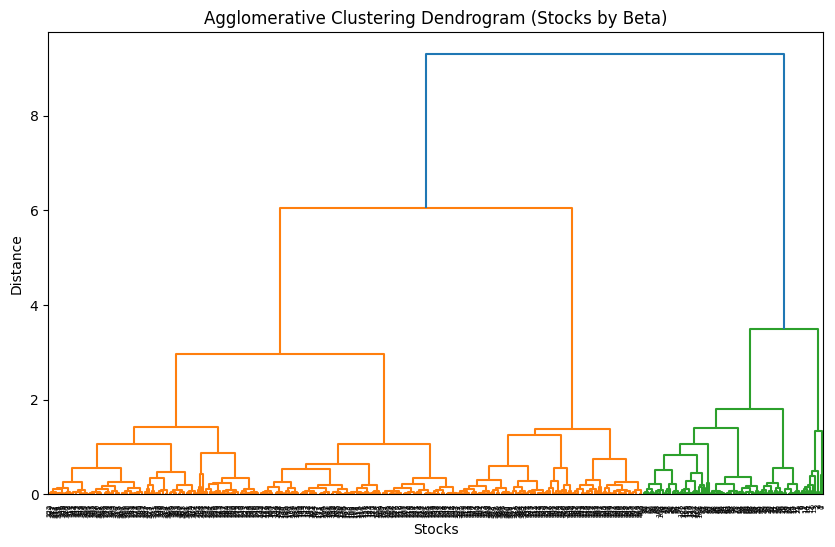

Silhouette Scores for different K values:
K=2, Silhouette Score=0.486
K=3, Silhouette Score=0.450
K=4, Silhouette Score=0.441
K=5, Silhouette Score=0.385


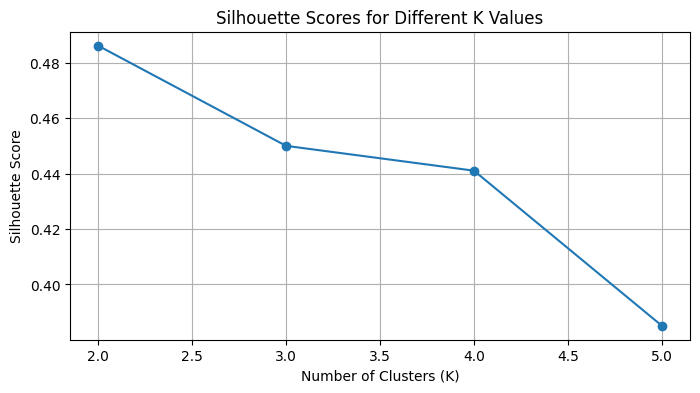


Top 8 Stocks by Beta:


,Stock_Symbol,Stock_Symbol,Beta,Cluster
0,0,0,2.895672,0
1,1,1,2.538507,0
2,2,2,2.191369,0
3,3,3,2.189063,0
4,4,4,2.148510,0
5,5,5,2.045402,0
6,6,6,1.983193,0
7,7,7,1.982958,0



Cluster Profiles (Beta statistics):


,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,115.0,1.509419,0.290637,1.115135,1.312225,1.427361,1.612632,2.895672
1,261.0,0.957173,0.155710,0.625299,0.846766,0.962932,1.085482,1.260046
2,118.0,0.483606,0.115355,0.156525,0.413917,0.501559,0.576242,0.671630


In [72]:
#Question 3 (c)
#Building clean DataFrame directly
beta_df = beta_df[['Beta', 'Cluster']].reset_index()
beta_df.rename(columns={'index': 'Stock_Symbol'}, inplace=True)

#Plotting dendrogram
linked = linkage(X, method='ward')
plt.figure(figsize=(10, 6))
dendrogram(linked, labels=beta_df.index, orientation='top', distance_sort='descending')
plt.title("Agglomerative Clustering Dendrogram (Stocks by Beta)")
plt.xlabel("Stocks")
plt.ylabel("Distance")
plt.show()

silhouette_scores = []
K_range = range(2, 6)

#Trying different K values and calculate silhouette scores
print("Silhouette Scores for different K values:")
for k in K_range:
    model = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = model.fit_predict(X)
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)
    print(f"K={k}, Silhouette Score={score:.3f}")

#Plotting Silhouette
plt.figure(figsize=(8, 4))
plt.plot(list(K_range), silhouette_scores, marker='o')
plt.title("Silhouette Scores for Different K Values")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

#Choosing best K based on dendrogram + silhouette
best_k = 3
cluster_model = AgglomerativeClustering(n_clusters=best_k, linkage='ward')
beta_df['Cluster'] = cluster_model.fit_predict(X)

#Formatting output to match image style
beta_df = beta_df.reset_index()
beta_df.rename(columns={'index': 'Stock_Symbol'}, inplace=True)

#Displaying top 8 stocks sorted by Beta
top_beta_df = beta_df.sort_values(by='Beta', ascending=False).head(8)
print("\nTop 8 Stocks by Beta:")
display(top_beta_df)

#Profile clusters
print("\nCluster Profiles (Beta statistics):")
cluster_profiles = beta_df.groupby('Cluster')['Beta'].describe()
cluster_profiles

Sample of merged dataset:
       Beta  Annual Volatility
0  2.895672           0.481664
1  2.538507           0.285599
2  2.191369           0.221213
3  2.189063           0.242071
4  2.148510           0.218262


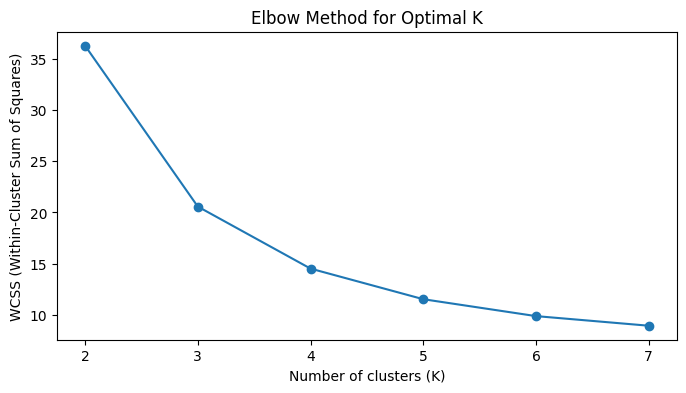

Silhouette Scores:
K=2, Silhouette Score=0.484
K=3, Silhouette Score=0.486
K=4, Silhouette Score=0.465
K=5, Silhouette Score=0.406
K=6, Silhouette Score=0.375
K=7, Silhouette Score=0.383

Selected K=3

Cluster Profiles (mean Beta & Annual Volatility):
             Beta  Annual Volatility
Cluster                             
0        1.070856           0.300259
1        0.571521           0.322451
2        1.664234           0.321115


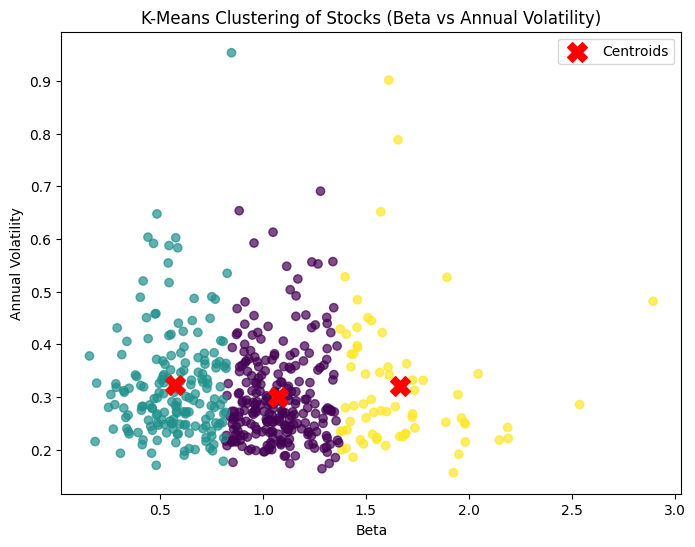

In [69]:
#Question 4 (c)
beta_df_reset = beta_df.reset_index(drop=True)
annual_vol_df_reset = annual_vol_df.reset_index(drop=True)

metrics_df = pd.concat([beta_df_reset['Beta'], annual_vol_df_reset['Annual Volatility']], axis=1)

print("Sample of merged dataset:")
print(metrics_df.head())


#Elbow Method
#Checking WCSS (within-cluster sum of squares) for different K values
X = metrics_df.values

wcss = []
for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plotting WCSS vs K to see the elbow
plt.figure(figsize=(8, 4))
plt.plot(range(2, 8), wcss, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of clusters (K)")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.show()

#Silhouette Scores
#Checking cluster separation with silhouette scores
print("Silhouette Scores:")
for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    print(f"K={k}, Silhouette Score={score:.3f}")

#Fit KMeans with chosen K
#Picking K=3 based on elbow & silhouette
best_k = 3
print(f"\nSelected K={best_k}")

kmeans = KMeans(n_clusters=best_k, random_state=42)
metrics_df['Cluster'] = kmeans.fit_predict(X)

#Profile clusters
#Cheking the average Beta and Volatility for each cluster
cluster_profiles = metrics_df.groupby('Cluster').mean()
print("\nCluster Profiles (mean Beta & Annual Volatility):")
print(cluster_profiles)

#Visualizing the clusters
plt.figure(figsize=(8, 6))
plt.scatter(metrics_df['Beta'], metrics_df['Annual Volatility'],
            c=metrics_df['Cluster'], cmap='viridis', alpha=0.7)

#Adding cluster centroids (red X)
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            c='red', marker='X', s=200, label='Centroids')

plt.xlabel("Beta")
plt.ylabel("Annual Volatility")
plt.title("K-Means Clustering of Stocks (Beta vs Annual Volatility)")
plt.legend()
plt.show()

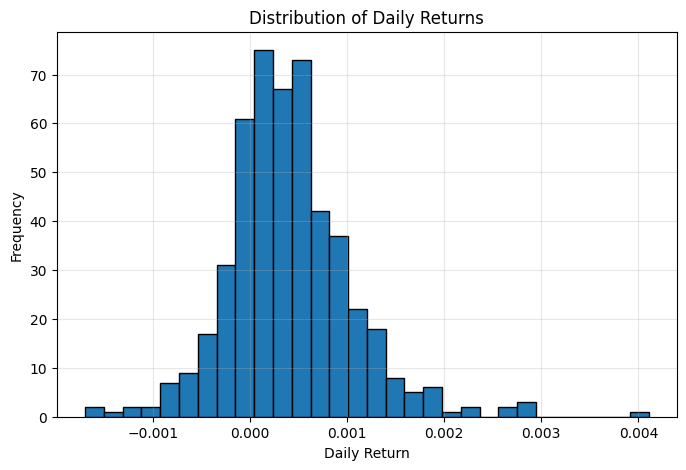

In [77]:
#Question 5
#Daily Return Distribution
avg_daily_return = daily_return.mean()
metrics_df["Daily Return"] = avg_daily_return.values

plt.figure(figsize=(8,5))
plt.hist(metrics_df["Daily Return"], bins=30, edgecolor='black')
plt.title("Distribution of Daily Returns")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()

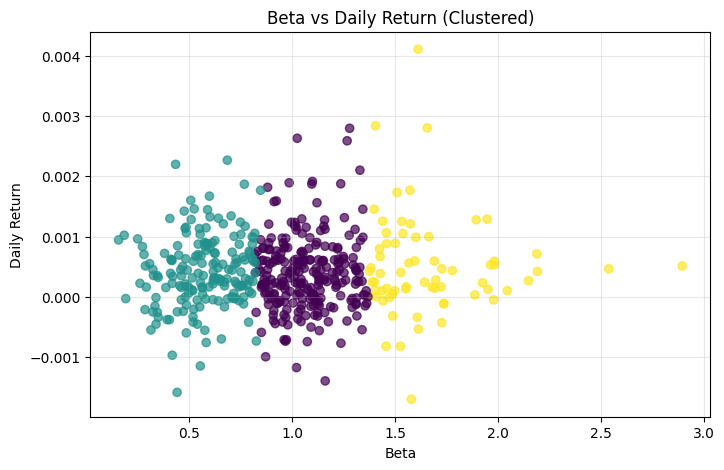

In [82]:
#Question 5
#Beta vs Daily Return
plt.figure(figsize=(8,5))
plt.scatter(metrics_df["Beta"], metrics_df["Daily Return"],
            c=metrics_df["Cluster"], cmap="viridis", alpha=0.7)
plt.title("Beta vs Daily Return (Clustered)")
plt.xlabel("Beta")
plt.ylabel("Daily Return")
plt.grid(alpha=0.3)
plt.show()

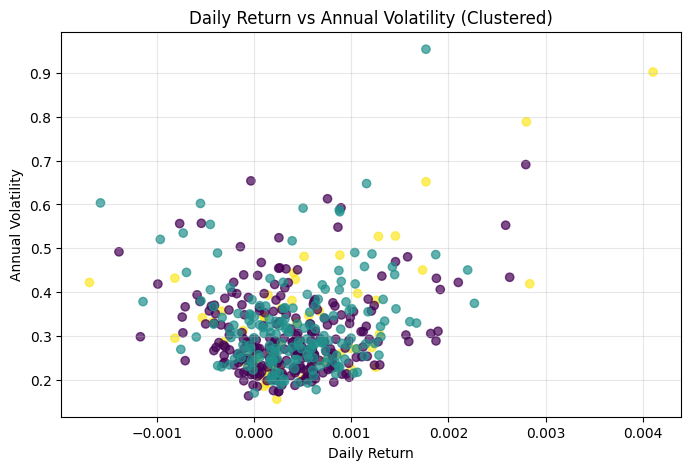

In [83]:
#Question 5
#Beta vs Annual Volatility
plt.figure(figsize=(8,5))
plt.scatter(metrics_df["Daily Return"], metrics_df["Annual Volatility"],
            c=metrics_df["Cluster"], cmap="viridis", alpha=0.7)
plt.title("Daily Return vs Annual Volatility (Clustered)")
plt.xlabel("Daily Return")
plt.ylabel("Annual Volatility")
plt.grid(alpha=0.3)
plt.show()